In [1]:
%reload_ext autoreload
%autoreload 2
from gen import generate_one_answer

In [1]:
import csv
import pandas as pd
max_len = 0
df = pd.DataFrame(columns=['Object 1', 'Object 2', 'Question', 'Best Answer',  'Answers'])

with open('yahoo_answers_positive_questions.csv', 'r') as file:
    reader = csv.reader(file)
    for ind, row in enumerate(reader):
        d = {'Object 1': row[0], 'Object 2': row[1], 'Question': row[2], 'Best Answer': row[3],  'Answers': [elem for elem in row[3:]]}
        if (ind > 0):
            df = df.append(d, ignore_index=True)

In [18]:
from bert_serving.client import BertClient
bc = BertClient()
a = bc.encode(['First do it', 'then do it right', 'then do it better'])

In [19]:
a[0][:10]

array([ 0.13186501,  0.32404107, -0.82704383, -0.51204693, -0.21091762,
       -0.0075642 ,  0.27821508,  0.14547256,  0.31613034, -0.80404204],
      dtype=float32)

In [20]:
a[1][:10]

array([ 0.24873537, -0.12334403, -0.38933882, -0.05058617, -0.28318736,
        0.00659929,  0.07119087,  0.523146  ,  0.2606893 , -0.4676088 ],
      dtype=float32)

In [16]:
from rouge_score import rouge_scorer

from sklearn.metrics.pairwise import cosine_similarity

from nltk.stem import porter
from nltk.tokenize import TweetTokenizer
import collections

stemmer = porter.PorterStemmer()
tokenizer = TweetTokenizer()

def create_ngrams(tokens, n): #сюда добавть эмбединги
    ngrams = collections.Counter()
    ngrams_embs = collections.Counter()
    for ngram in (tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)):
        ngrams[ngram] += 1
    return ngrams

def fmeasure(precision, recall):
  """Computes f-measure given precision and recall values."""

  if precision + recall > 0:
    return 2 * precision * recall / (precision + recall)
  else:
    return 0.0

def cos_sim(emb1, emb2):
    return cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))

def count_ngram_overlap(ngram1_embs, ngram2_embs): #The idea count cousine similarity to every pair. If > 0.6 than add
    result = 1
    #print ("ngram1_embs", len(ngram1_embs), len(ngram1_embs[0]))
    for elem in ngram1_embs: # по словам в н-граме
        similarities = [cos_sim(elem, elem2)[0][0] if cos_sim(elem, elem2) >= 0.6 else 0 for elem2 in ngram2_embs]
        #print (similarities)
        max_ = max(similarities)
        result *= max_
    return result
        

def count_overlap(ngram, ngram_emb, list_of_ngrams2, list_of_ngrams2_embs): # only if ngram not in list_of_ngrams !!!
    overlaps = [count_ngram_overlap(ngram_emb, elem[1]) for elem in list_of_ngrams2_embs] # по всем н-грамам
    return max(overlaps)

def score_ngrams(target_ngrams, prediction_ngrams):
    intersection_ngrams_count_pred = 0
    intersection_ngrams_count_tg = 0
    
    #print ("target_ngrams", target_ngrams.keys())
    #print ("prediction_ngrams", prediction_ngrams.keys())
    
    embeddings_target = bert_embedding([' '.join(elem)for elem in list(target_ngrams.keys())])
    embeddings_predictions = bert_embedding([' '.join(elem)for elem in list(prediction_ngrams.keys())])
    
    for ind, ngram in enumerate(list(target_ngrams.keys())):
        #print ("ind", ind)
        intersection_ngrams_count_tg += min(target_ngrams[ngram],
                                         prediction_ngrams[ngram])
        #print ("min", min(target_ngrams[ngram], prediction_ngrams[ngram]))
        if (min(target_ngrams[ngram], prediction_ngrams[ngram]) == 0):
            #print ("ngram", ngram)
            #print ('overlap')
            overlap_ngram = count_overlap(ngram, embeddings_target[ind][1], prediction_ngrams, embeddings_predictions) #по всем н-грамам
            #print ('overlap ngram', overlap_ngram)
            intersection_ngrams_count_tg += overlap_ngram
            
    for ind, ngram in enumerate(list(prediction_ngrams.keys())):
        #print ("ind", ind)
        intersection_ngrams_count_tg += min(target_ngrams[ngram],
                                         prediction_ngrams[ngram])
        #print ("min", min(target_ngrams[ngram], prediction_ngrams[ngram]))
        if (min(target_ngrams[ngram], prediction_ngrams[ngram]) == 0):
            #print ("ngram", ngram)
            #print ('overlap')
            overlap_ngram = count_overlap(ngram, embeddings_predictions[ind][1], prediction_ngrams, embeddings_target) #по всем н-грамам
            #print ('overlap ngram', overlap_ngram)
            intersection_ngrams_count_pred += overlap_ngram
            
    target_ngrams_count = sum(target_ngrams.values())
    prediction_ngrams_count = sum(prediction_ngrams.values())
    
    precision = intersection_ngrams_count_pred / max(prediction_ngrams_count, 1)
    recall = intersection_ngrams_count_tg / max(target_ngrams_count, 1)
    
    f = fmeasure(precision, recall)
    return f, precision, recall

def score_ngrams_v0(target_ngrams, prediction_ngrams):
    intersection_ngrams_count = 0
    
    #print ("target_ngrams", target_ngrams)
    #print ("prediction_ngrams", prediction_ngrams)
    
    embeddings_target = bert_embedding([' '.join(elem)for elem in list(target_ngrams.keys())])
    embeddings_predictions = bert_embedding([' '.join(elem)for elem in list(prediction_ngrams.keys())])
    
    for ind, ngram in enumerate(list(target_ngrams.keys())):
        #print ("ind", ind)
        intersection_ngrams_count += min(target_ngrams[ngram],
                                         prediction_ngrams[ngram])
        if (min(target_ngrams[ngram], prediction_ngrams[ngram]) == 0):
            #print ("ngram", ngram)
            #print ('overlap')
            overlap_ngram = count_overlap(ngram, embeddings_target[ind][1], prediction_ngrams, embeddings_predictions) #по всем н-грамам
            #print ('overlap ngram', overlap_ngram)
            intersection_ngrams_count += overlap_ngram
            
    target_ngrams_count = sum(target_ngrams.values())
    prediction_ngrams_count = sum(prediction_ngrams.values())
    
    #print ("intersection_ngrams_count", intersection_ngrams_count)
    #print ("intersection_targets_count", prediction_ngrams_count, target_ngrams_count)


    precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
    recall = intersection_ngrams_count / max(target_ngrams_count, 1)
    #print (precision, recall)
    
    f = fmeasure(precision, recall)
    return f, precision, recall

from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

def simple_rouge(generated_answers, possible_aswers_list):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
    rouge_1_list = []
    rouge_2_list = []
    for ind, elem in enumerate(generated_answers):
        if (elem != "We can't recognize objects for comparision"):
            generated_answer = generated_answers[ind]
            scores = [scorer.score(generated_answer, answ) for answ in possible_aswers_list[ind]]
            sorted_scores_1 = sorted(scores, key=lambda x: x['rouge1'].fmeasure, reverse = True)
            sorted_scores_2 = sorted(scores, key=lambda x: x['rouge2'].fmeasure, reverse = True)
            rouge_1_list.append(sorted_scores_1[0]['rouge1'])
            rouge_2_list.append(sorted_scores_2[0]['rouge2'])
    return {'rouge1':rouge_1_list, 'rouge2':rouge_2_list}


def rouge_cos(gen_answers, possible_answers):
    list_of_n1 = []
    list_of_n2 = []
    list_of_n3 = []
    for ind, elem in enumerate(gen_answers):
        print (ind)
        if (elem != "We can't recognize objects for comparision"):
            ngrams1 = create_ngrams(tokenizer.tokenize(elem), 1)
            answ_token_list = [tokenizer.tokenize(elemt) for elemt in possible_answers[0]]
            #scores_list_1 = [score_ngrams(ngrams1, create_ngrams(possible_answ, 1)) for possible_answ in answ_token_list]
            #sorted_scores_1 = sorted(scores_list_1, key=lambda x: x[0], reverse = True)
            #print ("target1", sorted_scores_1[0])
            #list_of_n1.append(sorted_scores_1[0])
            #print (ind, "n2")
            #ngrams01 = create_ngrams(tokenizer.tokenize(elem), 2)
            #scores_list_2 = [score_ngrams(ngrams01, create_ngrams(possible_answ, 2)) for possible_answ in answ_token_list]
            #sorted_scores_2 = sorted(scores_list_2, key=lambda x: x[0], reverse = True)
            #print ("target2", sorted_scores_2[0])
            #list_of_n2.append(sorted_scores_2[0])
            ngrams001 = create_ngrams(tokenizer.tokenize(elem), 3)
            scores_list_3 = [score_ngrams(ngrams001, create_ngrams(possible_answ, 3)) for possible_answ in answ_token_list]
            sorted_scores_3 = sorted(scores_list_3, key=lambda x: x[0], reverse = True)
            print ("target3", sorted_scores_3[0])
            list_of_n3.append(sorted_scores_3[0])
    return {'rouge1':list_of_n1, 'rouge2':list_of_n2, 'rouge3':list_of_n3}

In [2]:
import sys
import torch
from count_rouge import simple_rouge, rouge_cos3


In [6]:
with open('template_score3_.pkl', 'rb') as f:
    r3 = pickle.load(f)

In [8]:
import numpy as np
np.mean(np.array(r3['rouge3']))

0.02261789797751744

In [ ]:
import pickle

with open('cam_answers1.pkl', 'rb') as f:
    template_answers = pickle.load(f)
templ_scors = rouge_cos3(template_answers[:100], df['Answers'].values[:100])
with open('cam_score3_.pkl', 'wb') as f:
    pickle.dump(templ_scors, f)

0
1
2
3
target3 (0.011686172071296071, 0.0062407829909539225, 0.09169150394401532)
4
5
target3 (0.046036352320734296, 0.03193900900038295, 0.0824113340921053)
6
target3 (0.0724029720481841, 0.06681907892091077, 0.07900522943948976)
7
target3 (0.011563533405216004, 0.006446416999450632, 0.056077127078113215)
8
9
target3 (0.016609153707893325, 0.022146965747418226, 0.013286809130026755)
10
target3 (0.016609153707893325, 0.022146965747418226, 0.013286809130026755)
11
target3 (0.022020799039727836, 0.017351450352337264, 0.030128507983242063)
12
target3 (0.02997299542233473, 0.04332746278725177, 0.02291124949869029)
13
target3 (0.018788948025364894, 0.020705589606136936, 0.017197076792733416)
14
target3 (0.016609153707893325, 0.022146965747418226, 0.013286809130026755)
15
target3 (0.018200834129242793, 0.018039350303178152, 0.01836523519670353)
16
target3 (0.01144149910520515, 0.006110119940999609, 0.08977176221007117)
17
18
target3 (0.02704476074173522, 0.08056483187515548, 0.0162498279326

In [17]:
import pickle
print ("cam_answers")   
with open('cam_answers1.pkl', 'rb') as f:
    cam_answers = pickle.load(f)
cam_scors = rouge_cos(cam_answers, df['Answers'].values)
with open('cam_score03.pkl', 'wb') as f:
    pickle.dump(cam_scors, f)

cam_answers
0
1
2
3
target_ngrams dict_keys([('microsoft', 'has', 'undeniable'), ('has', 'undeniable', 'advantages'), ('undeniable', 'advantages', '.'), ('advantages', '.', 'They'), ('.', 'They', 'are'), ('They', 'are', 'simpler'), ('are', 'simpler', ','), ('simpler', ',', 'friendlier'), (',', 'friendlier', 'and'), ('friendlier', 'and', 'easier'), ('and', 'easier', 'to'), ('easier', 'to', 'use'), ('to', 'use', '.')])
prediction_ngrams dict_keys([('How', 'can', 'you'), ('can', 'you', 'even'), ('you', 'even', 'ask'), ('even', 'ask', 'this'), ('ask', 'this', 'question'), ('this', 'question', 'yet'), ('question', 'yet', '?'), ('yet', '?', 'Only'), ('?', 'Only', 'the'), ('Only', 'the', 'Xbox'), ('the', 'Xbox', '360'), ('Xbox', '360', 'is'), ('360', 'is', 'out'), ('is', 'out', 'at'), ('out', 'at', 'the'), ('at', 'the', 'moment'), ('the', 'moment', 'and'), ('moment', 'and', 'that'), ('and', 'that', "hasn't"), ('that', "hasn't", 'even'), ("hasn't", 'even', 'been'), ('even', 'been', 'tested'), 

KeyboardInterrupt: 

In [95]:
df['Best Answer'][10]

'Rat and mouse are actually not scientific classifications. These words are common names for rodents that look alike to the casual eye.\n\nRat is used to describe medium-sized rodents with long thin tails. There are many species of rodent that are called rats -- kangaroo rats, cotton rats, Norway rats, black rats, African pouched rats, naked mole rats, wood rats, pack rats, Polynesian rats, and many others. These different rodent species may not be closely related to each other at all!\n\nMouse is used to describe tiny, sparrow-sized rodents with long thin tails. As with rats, there are many species of rodents called mice which may or may not be closely related to each other: house mice, field mice, deer mice, smoky mice, spiny mice, and dormice are all called mice.'

In [96]:
df['Answers'][10]

['Rat and mouse are actually not scientific classifications. These words are common names for rodents that look alike to the casual eye.\n\nRat is used to describe medium-sized rodents with long thin tails. There are many species of rodent that are called rats -- kangaroo rats, cotton rats, Norway rats, black rats, African pouched rats, naked mole rats, wood rats, pack rats, Polynesian rats, and many others. These different rodent species may not be closely related to each other at all!\n\nMouse is used to describe tiny, sparrow-sized rodents with long thin tails. As with rats, there are many species of rodents called mice which may or may not be closely related to each other: house mice, field mice, deer mice, smoky mice, spiny mice, and dormice are all called mice.',
 'Rat and mouse are actually not scientific classifications. These words are common names for rodents that look alike to the casual eye. Rat is used to describe medium-sized rodents with long thin tails. There are many s

In [91]:
%load_ext autoreload
%autoreload 2

from count_rouge_new import rouge_cos

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
gen_answers = [df.Answers[10][0]]
possible_answers = df.Answers[10]
possible_answers[0]

'Rat and mouse are actually not scientific classifications. These words are common names for rodents that look alike to the casual eye.\n\nRat is used to describe medium-sized rodents with long thin tails. There are many species of rodent that are called rats -- kangaroo rats, cotton rats, Norway rats, black rats, African pouched rats, naked mole rats, wood rats, pack rats, Polynesian rats, and many others. These different rodent species may not be closely related to each other at all!\n\nMouse is used to describe tiny, sparrow-sized rodents with long thin tails. As with rats, there are many species of rodents called mice which may or may not be closely related to each other: house mice, field mice, deer mice, smoky mice, spiny mice, and dormice are all called mice.'

In [67]:
list_of_n1

[(0.0, 0.0, 2.0)]

In [87]:
[df.Answers[10][2]]

["a rat is an animal, a mouse is a computer's hardware"]

In [114]:
rouge_cos1([df.Answers[10][0]], [df.Answers[10][2]])

0
Rat and mouse are actually not scientific classifications. These words are common names for rodents that look alike to the casual eye.

Rat is used to describe medium-sized rodents with long thin tails. There are many species of rodent that are called rats -- kangaroo rats, cotton rats, Norway rats, black rats, African pouched rats, naked mole rats, wood rats, pack rats, Polynesian rats, and many others. These different rodent species may not be closely related to each other at all!

Mouse is used to describe tiny, sparrow-sized rodents with long thin tails. As with rats, there are many species of rodents called mice which may or may not be closely related to each other: house mice, field mice, deer mice, smoky mice, spiny mice, and dormice are all called mice.
target_ngrams 76
prediction_ngrams 9
target1 (0.4255484593227026, 0.42695072293281555, 0.42415537666051817)
target_ngrams 121
prediction_ngrams 11
target2 (0.7016925133386461, 0.858322490345348, 0.5934055878270057)
target_ngra

{'rouge1': [(0.4255484593227026, 0.42695072293281555, 0.42415537666051817)],
 'rouge2': [(0.7016925133386461, 0.858322490345348, 0.5934055878270057)],
 'rouge3': [(0.738389664764429, 0.8275334715843201, 0.6665837335122096)]}

In [8]:
df.head()

,Object 1,Object 2,Question,Best Answer,Answers
0,microsoft,sony,which next-gen console is the best NITENDO SON...,How can you even ask this question yet? Only t...,[How can you even ask this question yet? Only ...
1,microsoft,sony,"wich is better, the Sony play station or the M...","For a wide selection, choose PS2. However, XBO...","[For a wide selection, choose PS2. However, XB..."
2,microsoft,sony,Who do you think will win the next-gen war Son...,PS3 hands down,"[PS3 hands down, PS3 hands down, I think Sony ..."
3,microsoft,sony,Which do you prefer Sony's PS3 or Microsoft's ...,I'll comment on PS3 when it's out but I am loo...,[I'll comment on PS3 when it's out but I am lo...
4,microsoft,sony,PS3 or X-BOX 360? We all know that these are t...,I'm sure you knew when you posted this that we...,[I'm sure you knew when you posted this that w...


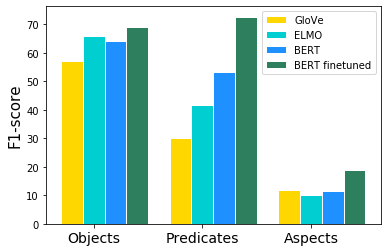

In [202]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.20

labels = ['Objects', 'Predicates', 'Aspects']
simple = [57.22, 30.1, 11.98]
elmo = [66.03, 41.57, 10.26]
bert = [64.24, 53.25, 11.46]
bert_plus = [69.21, 72.70, 19.05]
 
# set height of bar
bars1 = [12, 30, 1, 8, 22]
bars2 = [28, 6, 16, 5, 10]
bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(simple))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, simple, color='gold', width=barWidth, edgecolor='white', label='GloVe')
plt.bar(r2, elmo, color='darkturquoise', width=barWidth, edgecolor='white', label='ELMO')
plt.bar(r3, bert, color='dodgerblue', width=barWidth, edgecolor='white', label='BERT')
plt.bar(r4, bert_plus, color='#2d7f5e', width=barWidth, edgecolor='white', label='BERT finetuned')
 
# Add xticks on the middle of the group bars
plt.ylabel('F1-score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(simple))], ['Objects', 'Predicates', 'Aspects'], fontsize=14)
 
# Create legend & Show graphic
plt.legend()
plt.savefig("F1_nlu.png")
plt.show()


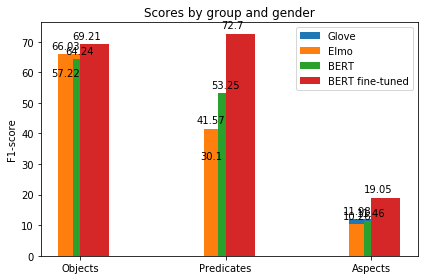

In [187]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Objects', 'Predicates', 'Aspects']
simple = [57.22, 30.1, 11.98]
elmo = [66.03, 41.57, 10.26]
bert = [64.24, 53.25, 11.46]
bert_plus = [69.21, 72.70, 19.05]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/4, simple, width, label='Glove')
rects2 = ax.bar(x - width/4, elmo, width, label='Elmo')
rects3 = ax.bar(x + width/4, bert, width, label='BERT')
rects4 = ax.bar(x + width/2, bert_plus, width, label='BERT fine-tuned')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-score')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 4, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

In [176]:
answer_small[0]

'honda is better than toyota because it is quicker, bigger, nicer. And it has some of the best engines in the market. But it is still competitive. The good news is that Honda is in the very early stages of making the right choice for the sportscar market. The bad news is that Honda is not taking any of the market-leading advantages of Toyota or Honda.'

In [22]:
list_of_template_answers

['after much thought, I realized that  honda is better, because: quicker, bigger, nicer, weaker.. But i should tell you that toyota is: lighter, easier, faster, softer.',
 'i came to the conclusion that motorola is better, because: better for me, bigger, easier for me to hold it, quicker., but nokia is: easier, faster, cheaper, t720.',
 'Looks like nokia is better, because: days, richer, easier to beat, easier to open and app or enddial a call.. But i should tell you that samsung is: quicker, greater, faster, smart.',
 "It's simple! php is better, because: easier to learn, easier to pick up for a noob, easier, java.. But i should tell you that javascript is: animation, easier to understand, faster, features.",
 'Looks like ruby is better, because: easier, easier to read, easier to learn, simpler.. But it will be useful for you to know that perl is: faster, cleaner, faster to write in ruby, safer.',
 "It's simple! aluminium is better, because: faster, lighter, easier to mod, greater.. B

In [24]:
my_extractor = extractor()
my_diviner = Templ

def generate_answer(my_extractor, my_diviner, input_string):
    my_extractor.from_string(input_string)
    print ("9")
    my_responser = responser()
    print ("9")
    try:
        obj1, obj2, predicates = my_extractor.get_params()
    except:
        return ("smth wrong in extractor, please try again")
    print ("9")
    print ("len(obj1), len(obj2)", len(obj1), len(obj2))
    print ("obj1, obj2, predicates", obj1, obj2, predicates)
    if (len(obj1) > 0 and len(obj2) > 0):
        response =  my_responser.get_response(first_object = obj1, second_object = obj2, fast_search=True, aspects = predicates, weights = [1 for predicate in predicates])
        try:
            response_json = response.json()
        except:
            return ("smth wrong in response, please try again")
        try:
            my_diviner.create_from_json(response_json, predicates)
            print (2)
        except:
            return ("smth wrong in diviner, please try again")
        try:
            answer = my_diviner.generate_advice()
            print ("answer0", answer)
        except:
            return ("smth wrong in answer generation, please try again")
    elif (len(obj1) > 0 and len(obj2) == 0):
        print ("len(obj1) > 0 and len(obj2) == 0")
        response =  my_responser.get_response(first_object = obj1, second_object = 'and', fast_search=True, aspects = predicates, weights = [1 for predicate in predicates])
        try:
            response_json = response.json()
            my_diviner = Cam
            my_diviner.create_from_json(response_json, predicates)
            answer = my_diviner.generate_advice(is_object_single = True)
            print ("answer1", answer)  
        except:
            answer = "smth wrong in response, please try again"
    else:
        answer = "We can't recognize objects for comparision"
    return answer

will be loaded
loading
extract_objects_predicates gpu 2


In [8]:
list_of_template_answers = []
list_of_given_qwestions = ["What is better Toyota or Honda ?", "What is better Nokia or Motorola ?", "What is better Nokia or Samsung ?", "What is better JavaScript or PHP", "What is better Perl or Ruby", "What is better aluminium or steel", "What is better beer or juice ?", "What is better beer or tea ? ",  "What is better laptop or iphone?" ]

In [173]:
from rouge_score import rouge_scorer

for ind, elem in enumerate(answer_big):
    print (ind, "target1")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
    scores = scorer.score(elem, list_of_target1[ind])
    print (scores)
    print (ind, "target2")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
    scores = scorer.score(elem, list_of_target2[ind])
    print (scores)
    print ("\n\n")

0 target1
{'rouge1': Score(precision=0.2222222222222222, recall=0.04, fmeasure=0.06779661016949154), 'rouge2': Score(precision=0.058823529411764705, recall=0.010101010101010102, fmeasure=0.01724137931034483)}
0 target2
{'rouge1': Score(precision=0.23376623376623376, recall=0.54, fmeasure=0.32628398791540786), 'rouge2': Score(precision=0.034782608695652174, recall=0.08080808080808081, fmeasure=0.0486322188449848)}



1 target1
{'rouge1': Score(precision=0.4406779661016949, recall=0.26262626262626265, fmeasure=0.3291139240506329), 'rouge2': Score(precision=0.02564102564102564, recall=0.015228426395939087, fmeasure=0.019108280254777073)}
1 target2
{'rouge1': Score(precision=1.0, recall=0.803030303030303, fmeasure=0.8907563025210083), 'rouge2': Score(precision=1.0, recall=0.8020304568527918, fmeasure=0.8901408450704225)}



2 target1
{'rouge1': Score(precision=0.3617021276595745, recall=0.14655172413793102, fmeasure=0.2085889570552147), 'rouge2': Score(precision=0.043478260869565216, recal

In [6]:
import pandas as pd 
  
# reading csv file  
ds = pd.read_csv("Evaluation dataset - Sheet1 (1).csv") 
list_of_target1 = ds['Q1']
list_of_target2 = ds['Q2']

In [11]:
list_of_template_answers

["It's simple! honda is better, because: quicker, bigger, nicer, weaker.. But you should know that toyota is: lighter, easier, faster, softer.",
 'I would prefer motorolla than nokia.',
 'I would prefer sumsung than nokia.',
 'Looks like php is better, because: easier to learn, easier to pick up for a noob, easier, java.. But it will be useful for you to know that javascript is: animation, easier to understand, faster, features.',
 'I would prefer to use ruby because it is: easier, easier to read, easier to learn, simpler.. But i should tell you that perl is: faster, cleaner, faster to write in ruby, safer.',
 'after much thought, I realized that  aluminium is better, because: faster, lighter, easier to mod, greater., but steel is: particles, drinks, ability, cks.',
 'I would prefer to use juice because it is: greater, faster, vitamen, water.. But you should know that beer is: lighter, better for you, easier, worse for your teeth.',
 'i came to the conclusion that tea is better, becaus

In [26]:
my_diviner = Templ

for elem in list_of_given_qwestions[45]:
    print ("qwestion ", elem)
    answer = generate_answer(my_extractor, my_diviner, elem)
    print ("answer ", answer)
    list_of_template_answers.append(answer)

IndexError: list index out of range

The reason why tea is better than beer is because it is very good for your body. You need to drink more tea than beer. When you drink tea, you need less alcohol. This is why tea is better than beer. How long it takes to make a cup of tea?
It is a long process. You need to wash your tea leaves and boil them, and then you need to boil them again. To make more tea, you need to boil the tea again. You need to boil the tea for at least one hour. Beer is life.


In [157]:
list_of_target2[8]

'I like tea, but seriously, there is no debate here at all. Beer is life. Why? Because beer goes with pizza. Isn’t that enough? Beer makes you social. Would you ever hang out with a person who drinks nothing than tea? If beer was bad, monks would’t sell it. I had the best time in my life while drinking beer. I tasted like 300 different beers, while only 10–20 different type of teas. Beer makes me happy, tea makes me nervous. We say, “Let me buy you a beer.” But how that sounds, “Let me buy you a tea”…'

In [114]:
answer_big = []

In [108]:
answer_big.append(sttr9)

In [125]:
sttr1 = "honda is better than toyota because it is quicker, bigger, nicer. The problem is that Honda is not the only one. Toyota has always been the king of the car world. There are a lot of other companies that have created the cars that people love. They do it for the money. But Toyota is the one that has to compete with Honda and Chevrolet. It has to produce cars that people want to buy.I am still not convinced that Toyota will ever get to that level. But it is not impossible. It is just a matter of time."

In [130]:
sttr2 = "Motorola is better than Nokia. And I'm not sure I've ever heard of a company that's better than Samsung. This is not a bad thing. I am not sure Samsung does a better job than Nokia.Well, it depends what you expect from a phone. If you want good build quality and regular software updates do not ever think of buy a phone of Chinese or Chinese-owned brand (except the phones running on Android One). If you have a tight budget, then you can proceed with Moto. Since Nokia’s phone are a bit overpriced, you may get one at reasonable price during sales. Also, the Nokia-exclusive Zeiss optics don’t have any competitor in their price range. If you want a Moto X4, then Nokia 7 Plus is always ahead. But if you want G5S Plus, then go on with it because Nokia 2.1 or 3.1 are the only available phones from Nokia and have a bit low specs. However you can go on for Nokia 6.1 or 6.1 Plus over Moto G6 because of their build quality and stock software anlog with regular updates and security patches."

In [133]:
sttr3 = "Samsung is better than Nokia. Nokia has no market share in the mobile phone industry, and it is not profitable. The company's strategy is to sell its devices to customers in China, and it is trying to win a share of the Chinese market. Samsung is also better than Nokia. Samsung has a high growth rate and is trying to establish itself as a leading player in the mobile phone industry. But Samsung has a long way to go to regain its market position. Samsung is now the second largest phone manufacturer in the world after Apple. The Nokia deal was announced in April, but it was not fully resolved until the end of July." 

In [139]:
sttr4 = "Php is better than javascript because it is easier to learn, easier to pick up. You should not use the PHP version of your application.You should not use the PHP version of your application. It is possible, but not recommended, that you must use PHP versions 5.3+ to use this framework. It is possible, but not recommended, that you must use PHP versions 5.3+ to use this framework. The PHP version of your application is not required to work, but it may prove to be beneficial. PHP is not required to work, but it may prove to be beneficial. You will not lose your development experience by using PHP. You will not lose your development experience by using PHP. PHP has a very advanced feature set. PHP has a very advanced feature set. PHP provides a very rich set of functions and modules. PHP provides a very rich set of functions and modules. PHP provides a high degree of flexibility and conciseness."

In [140]:
sttr5 = "Ruby is better than Python because ruby because it is: easier, easier to read, easier to learn, simpler. But you can also use any other language that works for you. For example, you can use Ruby instead of Python if you really, really want to. For me, Ruby and Python are the two languages that I use the most. If I had to pick a favorite language, Ruby would be the first one I'd pick. So that was the short version. In the next post, I'll go through some of the most important features of Ruby and Python that you might not know about. If you're curious about the future of Ruby, Python, or both, you can subscribe to the mailing list to get updates about upcoming posts."

In [142]:
sttr6 = "Aluminium is better than steel, because it is faster, lighter, easier to mod, greater. It also is more resistant to corrosion. The advantages of aluminium are many. However, it is also more expensive than steel. The steel is usually less expensive than aluminium because of the cost of the alloying process (which is why the price of steel is lower than aluminium). It is also usually harder (but not so much harder that it cannot be used) and more expensive. The main benefits of aluminium are. It is a good conductor of electricity. It is the strongest material known to man, and is also the only one that can resist all the shocks of a trip to the bathroom."

In [150]:
sttr7 = "Juice is better than beer because it is: greater, faster, vitamen. I don't think there is a reason to drink beer, but I do believe there is a reason to drink juice.I also don't believe there is a reason to drink beer. I think drinking beer is good for your teeth and keeping my mouth healthy."


In [158]:
sttr8 = "Tea is better than beer, because: easier, greater. The reason why tea is better than beer is because it is very good for your body. You need to drink more tea than beer. When you drink tea, you need less alcohol. This is why tea is better than beer. How long it takes to make a cup of tea?It is a long process. You need to wash your tea leaves and boil them, and then you need to boil them again. To make more tea, you need to boil the tea again. You need to boil the tea for at least one hour. Beer is life."

In [161]:
sttr9 = "Iphone is better than laptop because it is lighter, bigger, device, greater. If you have a smartphone, it is better than a laptop because it is lighter, bigger, device, greater. But it is not as good as laptop for some things like software development, software testing, or design.  It has a more stable battery, better image quality, better camera, and a better battery life. The iPhone 5s on the other hand is not a great laptop, it's not the best for a long time to come, but it is better than the iPhone 4 and 4s. And with the iPhone 6 and the iPhone 6 Plus, the iPhone 6s is better than the iPhone 6."

In [171]:
answer_big.append(sttr9)

In [172]:
answer_big

['honda is better than toyota because it is quicker, bigger, nicer. The problem is that Honda is not the only one. Toyota has always been the king of the car world. There are a lot of other companies that have created the cars that people love. They do it for the money. But Toyota is the one that has to compete with Honda and Chevrolet. It has to produce cars that people want to buy.I am still not convinced that Toyota will ever get to that level. But it is not impossible. It is just a matter of time.',
 "Motorola is better than Nokia. And I'm not sure I've ever heard of a company that's better than Samsung. This is not a bad thing. I am not sure Samsung does a better job than Nokia.Well, it depends what you expect from a phone. If you want good build quality and regular software updates do not ever think of buy a phone of Chinese or Chinese-owned brand (except the phones running on Android One). If you have a tight budget, then you can proceed with Moto. Since Nokia’s phone are a bit 

In [160]:
import os
text_generator_for_out("Iphone is better than laptop because it is lighter, bigger, device, greater.", LM_BIG)

  0%|          | 0/200 [00:00<?, ?it/s]

text_generator_for_out
exist3
exist4
exist


100%|██████████| 200/200 [00:08<00:00, 23.89it/s]

qu
======================================== SAMPLE 1 ========================================
in big gen2  It has a more stable battery, better image quality, better camera, and a better battery life.

The iPhone 5s on the other hand is not a great laptop, it's not the best for a long time to come, but it is better than the iPhone 4 and 4s. And with the iPhone 6 and the iPhone 6 Plus, the iPhone 6s is better than the iPhone 6.

All these devices are better than the iPhone 4s, but not by much. The iPhone 4s is a pretty mediocre laptop. If you want to buy a laptop, you should look at the Macbook Air. It is faster, cheaper, and better than the Apple MacBook Pros.

What is the most important thing you should know about the iPhone 4s?

The iPhone 4s is a pretty poor laptop. It's not as fast, or as powerful as the iPhone 5s, or as good as the Apple MacBook Pro.

But the iPhone 4
qu2
qu3


" It has a more stable battery, better image quality, better camera, and a better battery life.\n\nThe iPhone 5s on the other hand is not a great laptop, it's not the best for a long time to come, but it is better than the iPhone 4 and 4s. And with the iPhone 6 and the iPhone 6 Plus, the iPhone 6s is better than the iPhone 6.\n\nAll these devices are better than the iPhone 4s, but not by much. The iPhone 4s is a pretty mediocre laptop. If you want to buy a laptop, you should look at the Macbook Air. It is faster, cheaper, and better than the Apple MacBook Pros.\n\nWhat is the most important thing you should know about the iPhone 4s?\n\nThe iPhone 4s is a pretty poor laptop. It's not as fast, or as powerful as the iPhone 5s, or as good as the Apple MacBook Pro.\n\nBut the iPhone 4"

In [119]:
from GPT2.model import (GPT2LMHeadModel)
from GPT2.utils import load_weight
from GPT2.config import GPT2Config
from GPT2.sample import sample_sequence
from GPT2.encoder import get_encoder


def text_generator_for_out(text, model, length = 200, temperature = 0.7, top_k = 40):
    print("text_generator_for_out")
    
    device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
    print ("exist3")
    # Load Model
    enc = get_encoder()
    print ("exist4")

    quiet = False
    print ("exist")
    length = 200

    if length == -1:
        length = 1024 // 2
    elif length > 1024:
        raise ValueError("Can't get samples longer than window size: %s" % 1024)

    context_tokens = enc.encode(text)

    generated = 0
    for _ in range(1):
        out = sample_sequence(
            model=model, length=length,
            context=context_tokens,
            start_token=None,
            batch_size=1,
            temperature=temperature, top_k=top_k, device=device
        )
        out = out[:, len(context_tokens):].tolist()
        for i in range(1):
            generated += 1
            text = enc.decode(out[i])
            if quiet is False:
                print ("qu")
                print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
            print("in big gen2", text)
            print ("qu2")
            print ("qu3")
            return text

In [112]:
answer

'i came to the conclusion that python is better, because: quicker to develop code, quicker, matplotlib, easier.. But i should tell you that matlab is: faster, better for scientific computing, experience.'

In [4]:
import requests
URL = 'http://ltdemos.informatik.uni-hamburg.de/cam-api'
#proxies = {"http": "http://185.46.212.97:10015/","https": "https://185.46.212.98:10015/",}
params = {
            'objectA': 'Moscow',
            'objectB': 'London',
            'fs': str(True).lower()}
response = requests.get(url=URL, params=params)#, proxies=proxies)

## Rouge ##

In [13]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score('The quick brown dog jumps over the lazy fox',
                      'The quick brown dog jumps over the lazy fox.')
print (scores)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score('The quick brown dog jumps over the lazy fox',
                      'The fast hazel hound skips above the inactive tod.')
print (scores)

{'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rouge2': Score(precision=1.0, recall=1.0, fmeasure=1.0)}
{'rouge1': Score(precision=0.2222222222222222, recall=0.2222222222222222, fmeasure=0.2222222222222222), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}


## bert embeddings

## Bert embeddings

In [1]:
! nvcc --version

/bin/sh: 1: nvcc: not found


In [1]:
from bert_embedding import BertEmbedding

Bert embedding лучше учитывает контекст (так, что в словах "Я лублю яблоки" "Мне нравятся яблочные макбуки" Я - разное
В случае с service bert I -одинаковое apple одинаковок

I like apple
I like apple macbook

In [2]:
from bert_embedding import BertEmbedding

bert_abstract = """The quick brown dog jumps over the lazy fox.\n The fast hazel hound skips above inactive tod."""
sentences = bert_abstract.split('\n')
bert_embedding = BertEmbedding()
result = bert_embedding(sentences)

In [ ]:
nrgam ('jumps',)
list_of_ngrams Counter({('the',): 2, ('just',): 1, ('place',): 1, ('for',): 1, ('a',): 1, ('snark',): 1, ('bellman',): 1, ('cried',): 1})
[0.6792433]
[0.8161626]
[0.6827992]
[0]
[0.8117111]
[0]
[0]
[0.62362134]

In [461]:
result = bert_embedding(['jumps', 'just', 'a'])
vectors = result[0][1]
vectors1 = result[1][1]
vectors2 = result[2][1]

In [462]:
result[0][0]

['jumps']

## Count ngrams

In [308]:
for elem in list(ngrams1.keys()):
    print (' '.join(elem))

the quick
quick brown
brown dog
dog jumps
jumps over
over the
the lazy
lazy fox


In [15]:
tokenizer = TweetTokenizer()
bert_embedding = BertEmbedding()
import collections

str_1 = 'The quick brown dog jumps over the lazy fox'
str_2 = 'The fast hazel hound skips above the inactive tod.'
str_3 = 'Just the place for Snark the Bellman cried'
print ([str_1, str_2])
result = bert_embedding([str_1, str_2, str_3])
ngrams1_embeddings = result[0][1]
ngrams2_embeddings = result[1][1]
ngrams3_embeddings = result[2][1]

ngrams1 = create_ngrams(result[0][0], 2)
ngrams2= create_ngrams(result[1][0], 2)
ngrams3= create_ngrams(result[2][0], 2)

ngrams01 = create_ngrams(result[0][0], 1)
ngrams02= create_ngrams(result[1][0], 1)
ngrams03= create_ngrams(result[2][0], 1)

['The quick brown dog jumps over the lazy fox', 'The fast hazel hound skips above the inactive tod.']


In [491]:
ngrams1

Counter({('the', 'quick'): 1,
         ('quick', 'brown'): 1,
         ('brown', 'dog'): 1,
         ('dog', 'jumps'): 1,
         ('jumps', 'over'): 1,
         ('over', 'the'): 1,
         ('the', 'lazy'): 1,
         ('lazy', 'fox'): 1})

In [492]:
embeddings_target = bert_embedding([' '.join(elem)for elem in list(ngrams1.keys())])
embeddings_predictions = bert_embedding([' '.join(elem)for elem in list(ngrams2.keys())])
    

In [493]:
len(embeddings_target[1][1])

2

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def fmeasure(precision, recall):
  """Computes f-measure given precision and recall values."""

  if precision + recall > 0:
    return 2 * precision * recall / (precision + recall)
  else:
    return 0.0

def cos_sim(emb1, emb2):
    return cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))

def count_ngram_overlap(ngram1_embs, ngram2_embs): #The idea count cousine similarity to every pair. If > 0.6 than add
    result = 1
    #print ("ngram1_embs", len(ngram1_embs), len(ngram1_embs[0]))
    for elem in ngram1_embs: # по словам в н-граме
        similarities = [cos_sim(elem, elem2)[0][0] if cos_sim(elem, elem2) >= 0.6 else 0 for elem2 in ngram2_embs]
        #print (similarities)
        max_ = max(similarities)
        result *= max_
    return result
        

def count_overlap(ngram, ngram_emb, list_of_ngrams2, list_of_ngrams2_embs): # only if ngram not in list_of_ngrams !!!
    overlaps = [count_ngram_overlap(ngram_emb, elem[1]) for elem in list_of_ngrams2_embs] # по всем н-грамам
    return max(overlaps)

def score_ngrams(target_ngrams, prediction_ngrams):
    intersection_ngrams_count = 0
    
    #print ("target_ngrams", target_ngrams)
    #print ("prediction_ngrams", prediction_ngrams)
    
    embeddings_target = bert_embedding([' '.join(elem)for elem in list(target_ngrams.keys())])
    embeddings_predictions = bert_embedding([' '.join(elem)for elem in list(prediction_ngrams.keys())])
    
    for ind, ngram in enumerate(list(target_ngrams.keys())):
        #print ("ind", ind)
        intersection_ngrams_count += min(target_ngrams[ngram],
                                         prediction_ngrams[ngram])
        if (min(target_ngrams[ngram], prediction_ngrams[ngram]) == 0):
            #print ("ngram", ngram)
            #print ('overlap')
            overlap_ngram = count_overlap(ngram, embeddings_target[ind][1], prediction_ngrams, embeddings_predictions) #по всем н-грамам
            #print ('overlap ngram', overlap_ngram)
            intersection_ngrams_count += overlap_ngram
            
    target_ngrams_count = sum(target_ngrams.values())
    prediction_ngrams_count = sum(prediction_ngrams.values())
    
    #print ("intersection_ngrams_count", intersection_ngrams_count)
    #print ("intersection_targets_count", prediction_ngrams_count, target_ngrams_count)


    precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
    recall = intersection_ngrams_count / max(target_ngrams_count, 1)
    print (precision, recall)
    
    f = fmeasure(precision, recall)
    return f, precision, recall

In [11]:
from nltk.stem import porter
from nltk.tokenize import TweetTokenizer
import collections


stemmer = porter.PorterStemmer()
tokenizer = TweetTokenizer()

def create_ngrams(tokens, n): #сюда добавть эмбединги
    ngrams = collections.Counter()
    ngrams_embs = collections.Counter()
    for ngram in (tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)):
        ngrams[ngram] += 1
    return ngrams
    


In [19]:
list_of_template_answers[4]

'Looks like ruby is better, because: easier, easier to read, easier to learn, simpler.. But it will be useful for you to know that perl is: faster, cleaner, faster to write in ruby, safer.'

In [20]:
list_of_target1[4]

'Perl is an ideal choice for system administration work as well as the web development task whereas Ruby is highly suitable for the traffic-heavy application. ... Perl 5 is less Object-Oriented although Perl 6 has a very good Object-Oriented support whereas Ruby is highly Object-Oriented language.'

In [21]:
list_of_target2[4]

"I know a lot more Ruby than Perl, but the primary contrast is :Perl code is much terser than Ruby\nIf you want terse code that does its job in the least number of lines, Perl is better. If you want expressive, almost poetic and much more generally readable code, and don't mind the cost of a few extra characters, Ruby is much better. This manifests itself in several ways in practice:\n- Perl One liners (one line perl commands that perform batch manipulation:  of a bunch of files, for instance) are a cult in themselves - see Perl One Liners to get a feel.\n- Perl is better suited if the primary task is regex - Ruby regex syntax itself is pretty good, arguably close to Perl, but the typical use cases of doing text pattern matching with regexes are better expressed in Perl, in my view. Many developers do regexes with grep, and a natural progression for more complex manipulation not supported by grep is either through sed or awk for a class of tasks, or for more general power, to use Perl.

In [12]:
list_of_template_answers

['after much thought, I realized that  honda is better, because: quicker, bigger, nicer, weaker.. But i should tell you that toyota is: lighter, easier, faster, softer.',
 'i came to the conclusion that motorola is better, because: better for me, bigger, easier for me to hold it, quicker., but nokia is: easier, faster, cheaper, t720.',
 'Looks like nokia is better, because: days, richer, easier to beat, easier to open and app or enddial a call.. But i should tell you that samsung is: quicker, greater, faster, smart.',
 "It's simple! php is better, because: easier to learn, easier to pick up for a noob, easier, java.. But i should tell you that javascript is: animation, easier to understand, faster, features.",
 'Looks like ruby is better, because: easier, easier to read, easier to learn, simpler.. But it will be useful for you to know that perl is: faster, cleaner, faster to write in ruby, safer.',
 "It's simple! aluminium is better, because: faster, lighter, easier to mod, greater.. B

In [174]:
for ind, elem in enumerate(answer_big):
    print (ind, "n1")
    ngrams1 =create_ngrams(tokenizer.tokenize(elem), 1)
    ngrams2 =create_ngrams(tokenizer.tokenize(list_of_target1[ind]), 1)
    ngrams3 =create_ngrams(tokenizer.tokenize(list_of_target2[ind]), 1)
    print (elem)
    scores = score_ngrams(ngrams1, ngrams2)
    print ("target1", scores)
    scores = score_ngrams(ngrams1, ngrams3)
    print ("target2", scores)
    print (ind, "n2")
    ngrams01 =create_ngrams(tokenizer.tokenize(elem), 2)
    ngrams02 =create_ngrams(tokenizer.tokenize(list_of_target1[ind]), 2)
    ngrams03 =create_ngrams(tokenizer.tokenize(list_of_target2[ind]), 2)
    scores = score_ngrams(ngrams01, ngrams02)
    print ("target1", scores)
    scores = score_ngrams(ngrams01, ngrams03)
    print ("target2", scores)
    print ("\n\n")

0 n1
honda is better than toyota because it is quicker, bigger, nicer. The problem is that Honda is not the only one. Toyota has always been the king of the car world. There are a lot of other companies that have created the cars that people love. They do it for the money. But Toyota is the one that has to compete with Honda and Chevrolet. It has to produce cars that people want to buy.I am still not convinced that Toyota will ever get to that level. But it is not impossible. It is just a matter of time.
2.319214033453088 0.39343809496079174
target1 (0.6727491089405904, 2.319214033453088, 0.39343809496079174)
0.35589685977212054 0.8039455850209508
target2 (0.49338030423203555, 0.35589685977212054, 0.8039455850209508)
0 n2
0.4370502454986571 0.07087301278356602
target1 (0.12196751037171824, 0.4370502454986571, 0.07087301278356602)
0.1786614873475141 0.40560986316732933
target2 (0.24805892458167247, 0.1786614873475141, 0.40560986316732933)



1 n1
Motorola is better than Nokia. And I'm n

In [507]:
score_ngrams(ngrams01, ngrams02)

0.6794479370117188 0.7549421522352431


(0.7152083547491778, 0.6794479370117188, 0.7549421522352431)

In [508]:
score_ngrams(ngrams01, ngrams01)

1.0 1.0


(1.0, 1.0, 1.0)

In [509]:
score_ngrams(ngrams01, ngrams02)

0.6794479370117188 0.7549421522352431


(0.7152083547491778, 0.6794479370117188, 0.7549421522352431)

In [510]:
score_ngrams(ngrams01, ngrams03)

0.5479773506522179 0.487090978357527


(0.5157433888491462, 0.5479773506522179, 0.487090978357527)

In [392]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score('The quick brown dog jumps over the lazy fox',
                      'The fast hazel hound skips above inactive tod.')
print (scores)

{'rouge1': Score(precision=0.125, recall=0.1111111111111111, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0)}


In [ ]:
len(result[0][0])

In [ ]:
len(result[0][])

In [280]:
from bert_embedding import BertEmbedding

bert_abstract = """The quick brown dog jumps over the lazy fox.\n The fast hazel hound skips above inactive tod. \n Just the place for a Snark the Bellman cried"""
sentences = bert_abstract.split('\n')
print (sentences)
bert_embedding = BertEmbedding()
result = bert_embedding(sentences)

['The quick brown dog jumps over the lazy fox.', ' The fast hazel hound skips above inactive tod. ', ' Just the place for a Snark the Bellman cried']


## Our answer

In [159]:
import six
from six.moves import map
from six.moves import range

In [160]:
for ngram in six.iterkeys(ngrams1):
    print (ngram)
    print (ngrams1[ngram])
    print (ngrams2[ngram])
    print (min(ngrams1[ngram], ngrams2[ngram]))
    intersection_ngrams_count += min(ngrams1[ngram], ngrams2[ngram])
    

('The', 'quick')
1
0
0


NameError: name 'intersection_ngrams_count' is not defined

In [7]:
def _score_ngrams(target_ngrams, prediction_ngrams):
      """Compute n-gram based rouge scores.
      Args:
        target_ngrams: A Counter object mapping each ngram to number of
          occurrences for the target text.
        prediction_ngrams: A Counter object mapping each ngram to number of
          occurrences for the prediction text.
      Returns:
        A Score object containing computed scores.
      """

      intersection_ngrams_count = 0
      for ngram in six.iterkeys(target_ngrams):
        intersection_ngrams_count += min(target_ngrams[ngram],
                                         prediction_ngrams[ngram])
      target_ngrams_count = sum(target_ngrams.values())
      prediction_ngrams_count = sum(prediction_ngrams.values())

      precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
      recall = intersection_ngrams_count / max(target_ngrams_count, 1)
      fmeasure = scoring.fmeasure(precision, recall)

      return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)

In [8]:
## Measure

In [59]:
small = "I've used the Honda the past few years, and they're pretty good. They're just not as fast as a Toyota, but they're much more powerful, lighter, and more durable than the Toyota. They're more comfortable, they're more comfortable, and they're better.have been using the Honda for a while, and I can tell you that they're very good. They're just not as fast as a Toyota, but they're much more powerful, lighter, and more durable than the Toyota. They're more comfortable, they're more comfortable, and thy're better. They're just not as good as the Honda."

In [7]:
big = "They don\'t have that kind of engine. Maybe they are trying to make this bigger, faster, more powerful. You cannot afford to have a car with a big engine. You need to be careful when you make a big engine. There is no point, because it will explode. There is no point in spending a lot of money on a big engine.(CNN) After the shooting deaths of five police officers in Dallas last week, President Barack Obama offered condolences to the families of the fallen officers, calling the situation an attack on our shared humanity.Yet more than two months after the deaths of Alton Sterling in Louisiana and Philando Castile in Minnesota, the President did not issue a statement or call for unity or reflection. While we mourn for the officers who lost their lives in Dallas, we do not yet know the full extent of the threat that this attack represents, Obama said in a statement."

In [54]:
small

"I've used the Honda the past few years, and they're pretty good. They're just not as fast as a Toyota, but they're much more powerful, lighter, and more durable than the Toyota. They're more comfortable, they're more comfortable, and they're better.have been using the Honda for a while, and I can tell you that they're very good. They're just not as fast as a Toyota, but they're much more powerful, lighter, and more durable than the Toyota. They're more comfortable, they're more comfortable, and thy're better. They're just not as good as the Honda."

In [75]:
result = bert_embedding([gen_templates])

In [79]:
from nltk.stem import porter
from nltk.tokenize import TweetTokenizer


stemmer = porter.PorterStemmer()
tokenizer = TweetTokenizer()

In [81]:


ngrams1 = create_ngrams(tokenizer.tokenize(gen_templates), 2)
ngrams2= create_ngrams(tokenizer.tokenize(small), 2)
ngrams3= create_ngrams(tokenizer.tokenize(big), 2)

ngrams01 = create_ngrams(tokenizer.tokenize(gen_templates), 1)
ngrams02= create_ngrams(tokenizer.tokenize(small), 1)
ngrams03= create_ngrams(tokenizer.tokenize(big), 1)

In [49]:
gen_templates

'After much thought, I realized that Honda is better, because: quicker, bigger, nicer, weaker, but Toyota is lighter, easier, faster, softer.'

In [94]:

ngrams1_t = create_ngrams(tokenizer.tokenize(target1), 2)
ngrams2_t= create_ngrams(tokenizer.tokenize(target2), 2)

ngrams01_t = create_ngrams(tokenizer.tokenize(target1), 1)
ngrams02_t = create_ngrams(tokenizer.tokenize(target2), 1)


In [92]:
score_ngrams(ngrams01, ngrams01_t)

0.0821059115319384 0.6491498630493879


(0.14577400433389767, 0.0821059115319384, 0.6491498630493879)

In [95]:
score_ngrams(ngrams01, ngrams02_t)

0.38255592389982573 0.5857887584716082


(0.4628454387923817, 0.38255592389982573, 0.5857887584716082)

In [97]:
score_ngrams(ngrams02, ngrams01_t)

0.22225900106279275 0.5020672077579158


(0.30811795763773464, 0.22225900106279275, 0.5020672077579158)

In [98]:
score_ngrams(ngrams02, ngrams02_t)

0.7212211319378444 0.31553424522280693


(0.439004167266514, 0.7212211319378444, 0.31553424522280693)

In [100]:
score_ngrams(ngrams03, ngrams01_t)

0.4667321349321147 0.6709274439649149


(0.5505045694071096, 0.4667321349321147, 0.6709274439649149)

In [99]:
score_ngrams(ngrams03, ngrams02_t)

1.6459892696263838 0.4582583762028001


(0.7169197707706028, 1.6459892696263838, 0.4582583762028001)

In [91]:
ngrams1_t

Counter({('I', 'drive'): 1,
         ('drive', 'a'): 1,
         ('a', 'Honda'): 1,
         ('Honda', 'and'): 1,
         ('and', 'my'): 1,
         ('my', 'wife'): 1,
         ('wife', 'a'): 1,
         ('a', 'Toyota'): 1,
         ('Toyota', '.'): 1,
         ('.', 'So'): 1,
         ('So', 'by'): 1,
         ('by', 'owning'): 1,
         ('owning', 'both'): 1,
         ('both', 'cars'): 1,
         ('cars', 'I'): 1,
         ('I', 'have'): 1,
         ('have', 'experienced'): 1,
         ('experienced', 'both'): 1,
         ('both', 'brands'): 2,
         ('brands', '.'): 2,
         ('.', 'I'): 1,
         ('I', '’'): 1,
         ('’', 've'): 1,
         ('ve', 'been'): 1,
         ('been', 'driving'): 1,
         ('driving', 'a'): 1,
         ('a', 'honda'): 1,
         ('honda', 'city'): 1,
         ('city', 'AT'): 1,
         ('AT', 'for'): 1,
         ('for', 'almost'): 1,
         ('almost', '7'): 1,
         ('7', 'years'): 1,
         ('years', 'and'): 1,
         ('and', '

In [28]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score(gen_templates, target1)
scores

In [29]:
scores

{'rouge1': Score(precision=0.025974025974025976, recall=0.2857142857142857, fmeasure=0.04761904761904762),
 'rouge2': Score(precision=0.004347826086956522, recall=0.05, fmeasure=0.008)}

In [30]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score(small, target1)
scores

{'rouge1': Score(precision=0.17316017316017315, recall=0.3669724770642202, fmeasure=0.2352941176470588),
 'rouge2': Score(precision=0.02608695652173913, recall=0.05555555555555555, fmeasure=0.03550295857988165)}

In [31]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score(big, target1)
scores

{'rouge1': Score(precision=0.23809523809523808, recall=0.34375, fmeasure=0.28132992327365725),
 'rouge2': Score(precision=0.02608695652173913, recall=0.03773584905660377, fmeasure=0.030848329048843187)}

In [42]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
scores = scorer.score(target1, gen_templates)
scores

{'rouge1': Score(precision=0.2857142857142857, recall=0.025974025974025976, fmeasure=0.04761904761904762),
 'rouge2': Score(precision=0.05, recall=0.004347826086956522, fmeasure=0.008)}

In [36]:
target2

"In terms of sheer corporate value, Toyota is the most successful, preponderant automaker in the world. Honda is much smaller with an overall value that's just 25 percent of Toyota's. Toyota also sells many more vehicles in the United States every year than Honda."